# Runge Kutta methods - generic implementation

In [1]:
# author: Christian Offen
# accompanying source code for the handbook article 
# "Solving ODEs for Nonlinear Dynamics with Symplectic and Geometric Integration" within "Handbook on Nonlinear Dynamics. Volume 2 Numerical Methods", World Scientific, editor: Vincent Acary

In [2]:
using Plots
using LinearAlgebra
using LaTeXStrings
using ProgressMeter

## Generic implementation of Runge--Kutta method

In [3]:
# 1-step with Runge--Kutta method
function RKStep(f,t0,x0,h,A,b)

    # A Butcher tabele
    # b weights
    # h step size
    # x0 init value (column)
    # t0 init time
    # f function handle of RHS accepting f(float,column vector)

    n = length(x0)
    s=size(A,1)
    c=A*ones(s)


    # each stage is a column vector
    # all those are placed next to each other hKold, hKnew

    tol = 1e-14

    hKold=h*zeros(n,s);
    fcast(tt,xx) = hcat(f.(eachcol(tt),eachcol(xx))...)
    hKnew=h*fcast(t0.+h*c', x0 .+ hKold*A')

    while norm(hKnew-hKold,2) > tol
        hKold = hKnew
        hKnew = h*fcast(t0.+h*c', x0 .+ hKold*A')
    end

    return x0 .+ hKnew*b

end

# N iterations with Runge--Kutta method
function RKStep(f,t0,x0,h,A,b,N::Int)

    # A Butcher tabelaux
    # b weights
    # h step size
    # x0 init value (column)
    # t0 init time
    # f function handle of RHS accepting f(float,column vector)
    # N number of steps

    Step(x) = RKStep(f,t0,x,h,A,b)

    # pre-allocation
    x = zeros(length(x0),N+1)
    x[:,1] = x0
    
    # iteration
    @showprogress for k=1:N
           x[:,k+1] = Step(x[:,k])
    end

    return x
end

RKStep (generic function with 2 methods)

In [4]:
# Runge-Kutta tableaus

# explicit Euler
A_E = hcat(0)
b_E = [1]

# implicit Euler
A_IE = hcat(1)
b_IE = [1]

# Explicit midpoint
A_EMP = [0 0; 1/2 0]
b_EMP = [0,1]

# RK4 classical
A_RK4 = [0 0 0 0; 1/3 0 0 0; -1/3 1 0 0; 1 -1 1 0]
b_RK4 = [1/8,3/8,3/8,1/8]

# Lobatto IIIA 4th order
A_LobattoIIIA = [0 0 0; 5/24 1/3 -1/24; 1/6 2/3 1/6];
b_LobattoIIIA = [1/6,2/3,1/6];

# Radau IA 3rd order
A_RadauIA = [1/4 -1/4; 1/4 5/12];
b_RadauIA = [1/4,3/4];

# discontinuous collocation based on Simpsons's 3/8 rule (Newton Cotes with 4 stages)
A_Simpson = [1/8 -1/4 1/8 0; 1/8 1/4 -1/24 0; 1/8 5/12 1/8 0; 1/8 1/4 5/8 0]
b_Simpson = [1/8,3/8,3/8,1/8];

## numerical experiments

In [5]:
# dynamical system (pendulum)
c=1.0; f(~,x) = [x[2];-c*sin(x[1])]; # RHS of differential equation f(float,column vector)

t0 = 0.; # init time
x0 = [1.;0.]; # init 

N=2000 # number of steps
h0=0.01 # step size
tt=0:h0:h0*N; # time mesh for plotting

In [6]:
# true motion of pendulum equation θ''+c*sin⁡θ=θ=0
# assuming vanishing initial velocity
# based on Abramowitz & Stegun, section 16.4, p571
include("src/pendulum_true_motion.jl") # load external source code definining exact solution Theta and its derivative
x1_analytical=(t->Theta(1,x0[1],t)).(tt); # evaluate exact solution Theta(c,theta0,t) 
x2_analytical=(t->Theta_deriv(1,x0[1],t)).(tt); # evaluate derivative of exact solution Theta(c,theta0,t) 

In [7]:
# perform numerical computations
x_E=RKStep(f,0.,x0,h0,A_E,b_E,N);
x_IE=RKStep(f,0.,x0,h0,A_IE,b_IE,N);
x_EMP=RKStep(f,0.,x0,h0,A_EMP,b_EMP,N);
x_RK4=RKStep(f,0.,x0,h0,A_RK4,b_RK4,N);
x_LobattoIIIA=RKStep(f,0.,x0,h0,A_LobattoIIIA,b_LobattoIIIA,N);
x_RadauIA=RKStep(f,0.,x0,h0,A_RadauIA,b_RadauIA,N);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


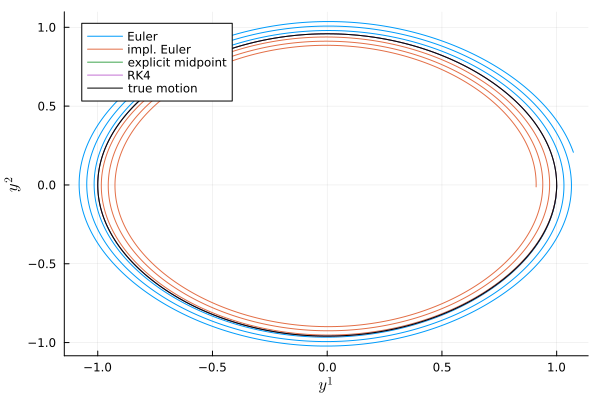

In [8]:
# plotting commands phase
plot_dyn=plot(xlabel=L"y^1",ylabel=L"y^2")
plot!(x_E[1,:],x_E[2,:],label="Euler")
plot!(x_IE[1,:],x_IE[2,:],label="impl. Euler")
plot!(x_EMP[1,:],x_EMP[2,:],label="explicit midpoint")
plot!(x_RK4[1,:],x_RK4[2,:],label="RK4")
plot!(x1_analytical,x2_analytical,label="true motion",color=:black)

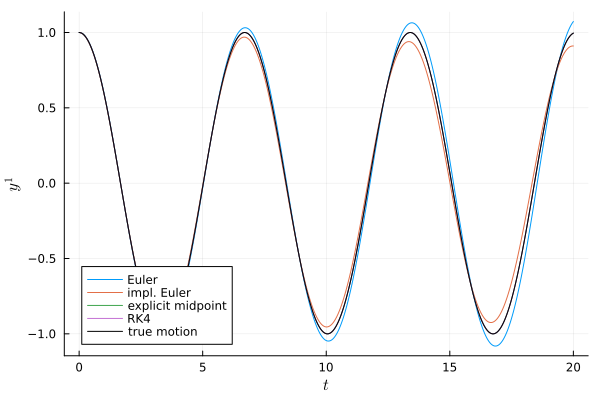

In [9]:
# plotting commands time evolution
plot_tt=plot(xlabel=L"t",ylabel=L"y^1")
plot!(tt,x_E[1,:],label="Euler")
plot!(tt,x_IE[1,:],label="impl. Euler")
plot!(tt,x_EMP[1,:],label="explicit midpoint")
plot!(tt,x_RK4[1,:],label="RK4")
plot!(tt,x1_analytical,label="true motion",color=:black)